# Deep Max Entropy Inverse Reinforcement Learning Based Reservoir Control

## Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.interpolate import Rbf
import scipy.special
import math
import datetime

from itertools import product
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
# Reading & processing data
df = pd.read_csv("Data/ResOpsUS/time_series_all/ResOpsUS_310.csv") # Grand Coulee Dam
df = df.dropna(subset = ["storage", "inflow", "outflow"])
df = df[["date", "storage", "outflow"]]
df = df.reset_index().drop(columns = ["index"])
df = df[~df.date.str.endswith('02-29')] # Get rid of 02-29 in leap years

# Calculate net inflow (inflow - evaporation, since evaporation data is rarely available)
# storage[t+1] - storage[t] + outflow[t]*86400/1000000 = inflow[t]*86400/1000000 - evaporation[t] = net_inflow[t] 
df["inflow"] = df["storage"].diff().shift(-1) + df["outflow"]*86400/1000000
# storage and net inflow in million cubic meters, outflow in cubic meters per second

In [3]:
# Train-test split
df_train = df[(df["date"] >= "1983-01-01") & (df["date"] < "2013-01-01")] # 1983-2012
df_test = df[(df["date"] >= "2013-01-01") & (df["date"] < "2018-01-01")] # 2013-2017

df_train

,date,storage,outflow,inflow
92,1983-01-01,5557.803,2548.512,163.493437
93,1983-01-02,5501.105,2707.086,191.550230
94,1983-01-03,5458.763,3256.432,276.659725
95,1983-01-04,5454.067,3114.848,306.737867
96,1983-01-05,5491.682,3369.699,395.214994
...,...,...,...,...
11045,2012-12-27,6016.196,3236.610,201.106104
11046,2012-12-28,5937.659,4139.916,328.362742
11047,2012-12-29,5908.333,4040.807,319.870725
11048,2012-12-30,5879.078,3717.996,262.933854


In [4]:
# Discretization
# Discretization parameter
D = 2

S_max = 6396  # Maximum reservoir storage is 5,185,400 acre⋅ft ~ 6396.1 km³
# max(df_train["storage"]) = 6396.151
S_step = int(10**D)  # Storage discretization step

A_max = 1000  # Maximum release
# max(df_train["outflow"]) = 722.15
A_step = int(10**D)  # Release discretization step (m³)

S_space = np.arange(0, S_max + S_step, S_step)  # Storage states
A_space = np.arange(0, A_max + A_step, A_step)  # Possible releases

In [5]:
# Building trajectories

# State (sin(2πt/365), cos(2πt/365), storage), action
# Yearly

storages, outflows, inflows = list(df_train["storage"]), list(df_train["outflow"]), list(df_train["inflow"])
storages = [storages[x:x+365] for x in (range(0, len(storages), 365))]
outflows = [outflows[x:x+365] for x in (range(0, len(outflows), 365))]
inflows = [inflows[x:x+365] for x in (range(0, len(inflows), 365))]

trajectories = []
states = []
for i in range(len(storages)):
    trajectories_i = []
    for j in range(365):
        trajectories_j = []
        #trajectories_i.append(math.sin(2*math.pi*j/365))
        #trajectories_i.append(math.cos(2*math.pi*j/365))
        trajectories_j.append(int(round(storages[i][j], -D)))
        trajectories_j.append(int(round(outflows[i][j]*86400/1000000, -D)))
        #trajectories_j.append(int(round(storages[i][j] + inflows[i][j] - outflows[i][j]*86400/1000000, -D)))
        trajectories_i.append(trajectories_j)
    trajectories.append(trajectories_i)
trajectories

[[[5600, 200],
  [5500, 200],
  [5500, 300],
  [5500, 300],
  [5500, 300],
  [5600, 200],
  [5800, 100],
  [6000, 200],
  [6200, 100],
  [6300, 200],
  [6400, 200],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 300],
  [6300, 200],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6400, 300],
  [6300, 300],
  [6300, 400],
  [6200, 400],
  [6100, 400],
  [6000, 400],
  [5900, 400],
  [5900, 300],
  [5800, 300],
  [5900, 300],
  [5900, 300],
  [5900, 300],
  [5900, 300],
  [6000, 300],
  [6100, 200],
  [6200, 300],
  [6200, 300],
  [6400, 200],
  [6400, 300],
  [6400, 300],
  [6200, 400],
  [6100, 400],
  [6000, 400],
  [5800, 400],
  [5700, 400],
  [5600, 400],
  [5500, 400],
  [5400, 500],
  [5300, 500],
  [5100, 500],
  [5000, 500],
  [4900, 400],
  [4800, 400],
  [4700, 400],
  [4500, 4

{0: 0.004201680672268909,
 100: 0.11719035440262715,
 200: 0.4554256485203131,
 300: 0.2833394227256071,
 400: 0.0897880891487014,
 500: 0.02813299232736585,
 600: 0.014157837047862654,
 700: 0.0058458165875045634,
 800: 0.0019181585677749355}

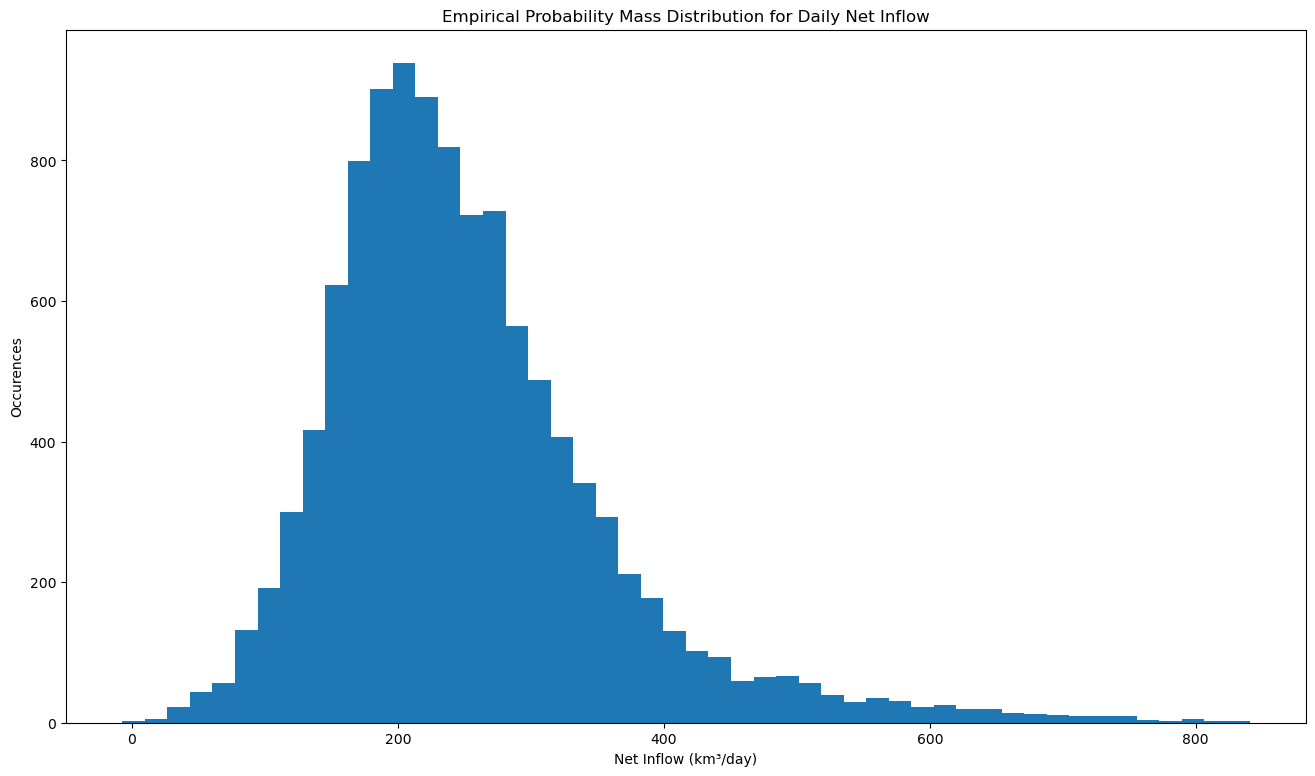

In [6]:
# Inflow distribution to sample from
 
inflows = list(df_train["inflow"])

inflows.remove(max(inflows)) # Abnormal value at 96-10-05 & 96-10-06 due to wrong storage value
inflows.remove(min(inflows))
fig = plt.figure(figsize=(16, 9))
num_bins = 50
n, bins, _ = plt.hist(inflows, num_bins)
plt.xlabel('Net Inflow (km³/day)')
plt.ylabel('Occurences')
plt.title('Empirical Probability Mass Distribution for Daily Net Inflow')

# Empricial pdf

inflows = sorted(list(map(int, inflows)))
inflows_pdf = {}
for i in range(round(min(inflows), -D), round(max(inflows), -D) + 10**D, 10**D):
    inflows_pdf[i] = 0
for j in inflows:
    if round(j, -D) in inflows_pdf.keys():
        inflows_pdf[round(j, -D)] += 1/len(inflows)
    else:
        print("error")
inflows_pdf

## Transition & Value Iteration

In [7]:
# Markov Chain Formalism

Transition_matrix = {}
# Initialization
for i in S_space:
    for j in S_space:
        for k in A_space:
            Transition_matrix[(i,j,k)] = 0

for i in S_space:
    start_state = i
    # print(i)
    for j in inflows_pdf.keys():
        inflow = j
        max_possible_release = start_state + inflow
        probability = inflows_pdf[inflow]
        for k in A_space:
            release = k
            if release <= max_possible_release: # Feasible release
                end_state = start_state + inflow - release
                Transition_matrix[(start_state, end_state, release)] = probability  

In [8]:
Transition_matrix

{(0, 0, 0): 0.004201680672268909,
 (0, 0, 100): 0.11719035440262715,
 (0, 0, 200): 0.4554256485203131,
 (0, 0, 300): 0.2833394227256071,
 (0, 0, 400): 0.0897880891487014,
 (0, 0, 500): 0.02813299232736585,
 (0, 0, 600): 0.014157837047862654,
 (0, 0, 700): 0.0058458165875045634,
 (0, 0, 800): 0.0019181585677749355,
 (0, 0, 900): 0,
 (0, 0, 1000): 0,
 (0, 100, 0): 0.11719035440262715,
 (0, 100, 100): 0.4554256485203131,
 (0, 100, 200): 0.2833394227256071,
 (0, 100, 300): 0.0897880891487014,
 (0, 100, 400): 0.02813299232736585,
 (0, 100, 500): 0.014157837047862654,
 (0, 100, 600): 0.0058458165875045634,
 (0, 100, 700): 0.0019181585677749355,
 (0, 100, 800): 0,
 (0, 100, 900): 0,
 (0, 100, 1000): 0,
 (0, 200, 0): 0.4554256485203131,
 (0, 200, 100): 0.2833394227256071,
 (0, 200, 200): 0.0897880891487014,
 (0, 200, 300): 0.02813299232736585,
 (0, 200, 400): 0.014157837047862654,
 (0, 200, 500): 0.0058458165875045634,
 (0, 200, 600): 0.0019181585677749355,
 (0, 200, 700): 0,
 (0, 200, 800): 0

In [ ]:
# Value iteration for deriving the policy
def value_iteration(P_a, N_STATES, N_ACTIONS, rewards, gamma, error, tau, deterministic=True):
  values = np.zeros([N_STATES])

  # estimate values
  while True:
    values_tmp = values.copy()
    # This will be heavy if the resolution is high e.g., (600*600*100)

    for s in range(N_STATES):
      v_s = []
      values[s] = max([sum([P_a[S_space[s], S_space[s1], A_space[a]]*(rewards[s][a][0] + gamma*values_tmp[s1]) 
                            for s1 in range(N_STATES)]) 
                            for a in range(N_ACTIONS)])

    if max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)]) < error:
      break

    # print("iteration done")

  policy = np.zeros((N_STATES, N_ACTIONS))
  for s in range(N_STATES):
      # compute Q[s,a] for all a
      Q_s = np.array([
          sum(
              P_a[S_space[s], S_space[s1], A_space[a]] *
              (rewards[s][a][0] + gamma * values[s1])
              for s1 in range(N_STATES)
          )
          for a in range(N_ACTIONS)
      ])

      if deterministic:
          # greedy
          best_a = np.argmax(Q_s)
          policy[s, best_a] = 1.0
      else:
          # Boltzmann (softmax) policy
          exp_Q = np.exp((Q_s - Q_s.max())/tau)
          policy[s,:] = exp_Q / exp_Q.sum()

  return values, policy

## Trajectories

In [10]:
# Obtained state-action visitation frequency from expert actions
def demo_svf(trajectories):
  p = np.zeros((len(S_space), len(A_space)))
  for i in trajectories:
      for j in i:
          S_index = int(j[0]/10**D)
          A_index = int(j[1]/10**D)
          p[S_index][A_index] += 1
  p = p/len(trajectories)
  return p

In [11]:
# Expected state-action vistation frequency from learned reward function
def compute_state_visition_freq(P_a, N_STATES, N_ACTIONS,
                                gamma, trajectories, policy,
                                deterministic=True):

    # horizon length from trajectories
    T = len(trajectories[0])

    # mu[s,t] = P(s_t = s)
    mu = np.zeros((N_STATES, T))

    # initialize from demonstrations at t=0
    for traj in trajectories:
        s0 = int(traj[0][0] / 10**D)
        mu[s0, 0] += 1
    mu /= len(trajectories)

    # forward propagate under π(a|s)
    for t in range(T - 1):
        for s in range(N_STATES):
            # build action‐prob vector at state s
            if deterministic:
                a_val = int(policy[s])
                a_probs = np.zeros(N_ACTIONS)
                a_probs[list(A_space).index(a_val)] = 1.0
            else:
                a_probs = policy[s]

            for a_idx, p_a in enumerate(a_probs):
                if p_a == 0:
                    continue
                a = A_space[a_idx]
                for s1 in range(N_STATES):
                    mu[s1, t+1] += mu[s, t] * p_a * P_a[S_space[s], S_space[s1], a]

    # accumulate state–action counts (undiscounted)
    p_sa = np.zeros((N_STATES, N_ACTIONS))
    for t in range(T):
        for s in range(N_STATES):
            if deterministic:
                a_idx = list(A_space).index(int(policy[s]))
                p_sa[s, a_idx] += mu[s, t]
            else:
                p_sa[s, :] += mu[s, t] * policy[s]

    return p_sa


## Neural Network

In [12]:
from tensorflow.keras import layers, models, regularizers

class DeepIRL(tf.keras.Model):
    def __init__(self, n_input, lr, n_h1=5, n_h2=5, name="deep_irl"):
        super(DeepIRL, self).__init__()
        self.n_input = n_input
        self.lr = lr

        # Build the model architecture
        self.fc1 = layers.Dense(n_h1, activation='relu', kernel_initializer='he_normal')
        self.fc2 = layers.Dense(n_h2, activation='relu', kernel_initializer='he_normal')
        self.reward_layer = layers.Dense(1)

        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        reward = self.reward_layer(x)
        return reward

    def get_rewards(self, state_action):
        state_action = tf.convert_to_tensor(state_action, dtype=tf.float32)
        return self(state_action).numpy()

    def get_theta(self):
        return [v.numpy() for v in self.trainable_variables]
    
    def apply_grads(self, feat_map, grad_r):
        feat_map = tf.convert_to_tensor(np.reshape(feat_map, [-1, self.n_input]), dtype=tf.float32)
        grad_r = tf.convert_to_tensor(np.reshape(grad_r, [-1, 1]), dtype=tf.float32)

        with tf.GradientTape() as tape:
            reward = self(feat_map)  # Forward pass: reward = model(feat_map)
            loss = tf.reduce_sum(-reward * grad_r)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Return gradients for debugging or analysis
        return [g.numpy() for g in grads], loss

## Training

The derivative of the Maximum Entropy objective with respect to the reward equals the difference in state visitation counts between solutions given by the expert demonstrations and the expected visitation counts for the learned systems trajectory distribution.

In [13]:
# Training parameters
n_iters = 100
n_states = len(S_space)
n_actions = len(A_space)
lr = 0.01
discount_rate = 0.95
error = 0.01
tau = 0.5  # <1 sharpens, >1 smooths

# Feature Map: All possible combinations of state-action pairs
feat_map = [[[v1,v2] for v1 in A_space] for v2 in S_space]

In [ ]:
##### Deep Max Entropy TraIRL 

# Initialize network
nn = DeepIRL(2, lr, 10, 10)

# Find state visitation frequencies from expert actions
mu_D = demo_svf(trajectories)
Loss = []
Epochs = range(1, n_iters+1)

### Training Loop
for iteration in range(n_iters):
    print("Iteration", iteration)
    
    # reward_i = nn_forward(f, parameters_i)
    rewards = nn.get_rewards(feat_map)
    print("forward done")

    ### Solving MDP with current reward function
    # value approximation to compute policy 
    _, policy = value_iteration(Transition_matrix, n_states, n_actions, rewards, discount_rate, error, tau, deterministic=False)
    print("policy analyzed")

    # Propagate policy by computing expected svf
    mu_exp = compute_state_visition_freq(Transition_matrix, n_states, n_actions, discount_rate, trajectories, policy, deterministic=False)
    print("policy propagated")

    ### Maximum Entropy
    # Gradients (dL/dr)
    grad_r = mu_D - mu_exp

    ### Network parameter update
    # Backpropagation (dL/dθ) & parameter update
    grad_theta, loss = nn.apply_grads(feat_map, grad_r)

    print("Loss =", float(loss))
    Loss.append(loss)

    ### Plotting the reward function learned
    rewards = nn.get_rewards(feat_map)
    x = list(S_space) * len(A_space)
    y = []
    for i in A_space:
        y = y + [i] * len(S_space)
    z = list(rewards.flatten())
    fig = plt.figure(figsize=(12, 6))

    # first subplot: 3D scatter
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(x, y, z)
    ax.set_xlabel('State')
    ax.set_ylabel('Action')
    ax.set_zlabel('Reward')
    ax.set_title('3D Reward Scatter')

    # second subplot: heatmap
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(
        data=np.squeeze(rewards),
        ax=ax2,
        cmap='viridis',
        cbar_kws={'label': 'Reward'}
    )
    ax2.invert_yaxis()
    ax2.set_xlabel('Action Index')
    ax2.set_ylabel('State Index')
    ax2.set_title('Reward Heatmap')

    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Training History')

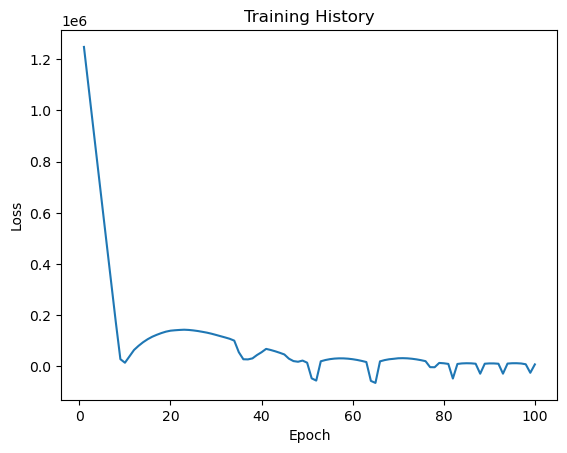

In [31]:
### Training history
plt.plot(Epochs, Loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')

## Validation

In [32]:
# Monte-Carlo Simulation given the policy and historical inflow

def simulate_validation(n_samples, policy, S_space, A_space, inflow_series, init_storage, D):
    # index maps
    s_to_i = {s:i for i,s in enumerate(S_space)}
    # starting state
    s = init_storage
    s_idx = s_to_i[s]
    
    T = len(inflow_series)
    step = 10**D
    
    trajectories_MC = []

    for i in range(n_samples):
        traj = []
        for t in range(T):
            inflow = inflow_series[t]
            # feasible actions: release ≤ s + inflow
            feas_mask = (A_space <= s + inflow)
            feas_idxs = np.nonzero(feas_mask)[0]
            # pick π(a|s) over only feasible actions
            p = policy[s_idx, feas_idxs]
            p = p / p.sum()

            # sample an action index (within feas_idxs)
            choice = np.random.choice(len(feas_idxs), p=p)
            a_idx = feas_idxs[choice]
            a = A_space[a_idx]

            traj.append(a)

            # deterministically update storage
            s_next = s + inflow - a
            # clip to valid range
            s_next = min(max(s_next, S_space[0]), S_space[-1])
            # discretize and look up index
            s_idx = int(round(s_next / step))
            s = S_space[s_idx]
        
        trajectories_MC.append(traj)

    return np.array(list(map(sum, zip(*trajectories_MC))))/n_samples

Text(0.5, 1.0, 'Simulation using the Recovered Reward Function on the Testing Dataset')

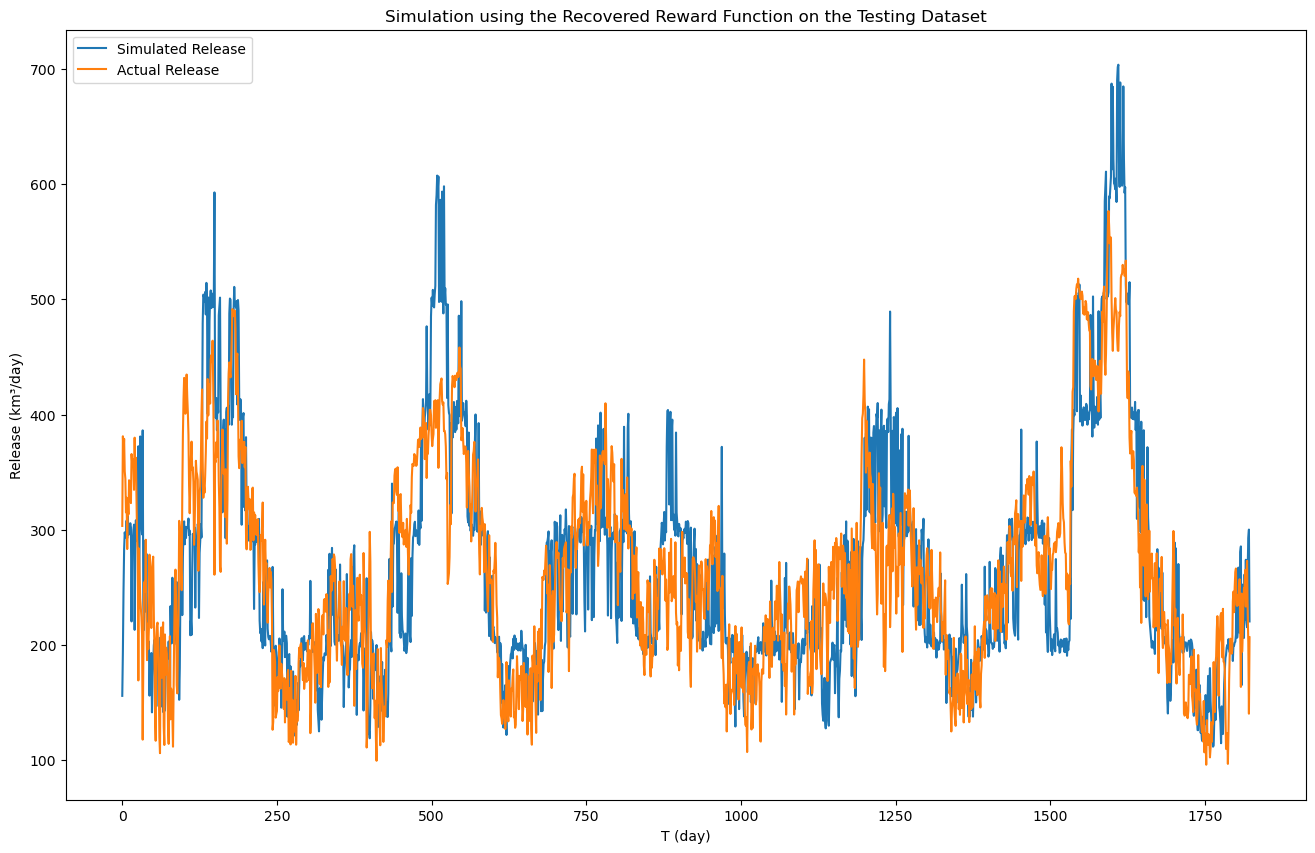

In [68]:
### Validation
D = 2
n_samples = 1000
inflow_series = list(df_test["inflow"])
init_storage = int(round(list(df_test["storage"])[0], -D))

trajectories_MC = simulate_validation(n_samples, policy, S_space, A_space, inflow_series, init_storage, D)

fig = plt.figure(figsize=(16, 10))
plt.plot(range(len(df_test["date"])), trajectories_MC)
plt.plot(range(len(df_test["date"])), df_test["outflow"]*86400/1000000)
plt.xlabel('T (day)')
plt.ylabel('Release (km³/day)')
plt.legend(["Simulated Release", "Actual Release"])
plt.title('Simulation using the Recovered Reward Function on the Testing Dataset')

Text(0.5, 1.0, 'Decreasing Marginal Rewards')

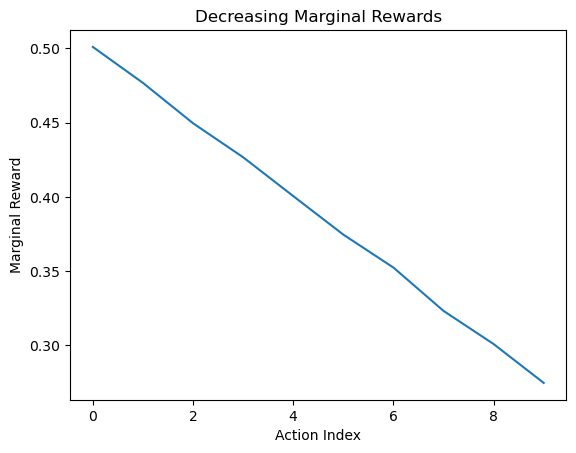

In [66]:
# Average Marginal reward plot

rewards = nn.get_rewards(feat_map)

marginal_rewards = []
for i in rewards:
    gradients_i = []
    for j in range(len(i) - 1):
        gradients_i.append((i[j+1][0] - i[j][0])/100)
    marginal_rewards.append(gradients_i)

marginal_rewards = pd.DataFrame(np.array(marginal_rewards))
marginal_rewards_mean = marginal_rewards.mean()

plt.plot(marginal_rewards_mean)
plt.xlabel('Action Index')
plt.ylabel('Marginal Reward')
plt.title('Decreasing Marginal Rewards')

## Alternatively, use Softplus as the activation function:

In [ ]:
from tensorflow.keras import layers, models, regularizers

class DeepIRL(tf.keras.Model):
    def __init__(self, n_input, lr, n_h1=5, n_h2=5, name="deep_irl"):
        super(DeepIRL, self).__init__()
        self.n_input = n_input
        self.lr = lr

        # Build the model architecture
        self.fc1 = layers.Dense(n_h1, activation='softplus', kernel_initializer='he_normal')
        self.fc2 = layers.Dense(n_h2, activation='softplus', kernel_initializer='he_normal')
        self.reward_layer = layers.Dense(1)

        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        reward = self.reward_layer(x)
        return reward

    def get_rewards(self, state_action):
        state_action = tf.convert_to_tensor(state_action, dtype=tf.float32)
        return self(state_action).numpy()

    def get_theta(self):
        return [v.numpy() for v in self.trainable_variables]
    
    def apply_grads(self, feat_map, grad_r):
        feat_map = tf.convert_to_tensor(np.reshape(feat_map, [-1, self.n_input]), dtype=tf.float32)
        grad_r = tf.convert_to_tensor(np.reshape(grad_r, [-1, 1]), dtype=tf.float32)

        with tf.GradientTape() as tape:
            reward = self(feat_map)  # Forward pass: reward = model(feat_map)
            loss = tf.reduce_sum(-reward * grad_r)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Return gradients for debugging or analysis
        return [g.numpy() for g in grads], loss

##### Deep Max Entropy TraIRL 

# Initialize network
nn = DeepIRL(2, lr, 10, 10)

# Find state visitation frequencies from expert actions
mu_D = demo_svf(trajectories)
Loss = []
Epochs = range(1, n_iters+1)

### Training Loop
for iteration in range(n_iters):
    print("Iteration", iteration)
    
    # reward_i = nn_forward(f, parameters_i)
    rewards = nn.get_rewards(feat_map)
    print("forward done")

    ### Solving MDP with current reward function
    # value approximation to compute policy 
    _, policy = value_iteration(Transition_matrix, n_states, n_actions, rewards, discount_rate, error, tau, deterministic=False)
    print("policy analyzed")

    # Propagate policy by computing expected svf
    mu_exp = compute_state_visition_freq(Transition_matrix, n_states, n_actions, discount_rate, trajectories, policy, deterministic=False)
    print("policy propagated")

    ### Maximum Entropy
    # Gradients (dL/dr)
    grad_r = mu_D - mu_exp

    ### Network parameter update
    # Backpropagation (dL/dθ) & parameter update
    grad_theta, loss = nn.apply_grads(feat_map, grad_r)

    print("Loss =", float(loss))
    Loss.append(loss)

    ### Plotting the reward function learned
    rewards = nn.get_rewards(feat_map)
    x = list(S_space) * len(A_space)
    y = []
    for i in A_space:
        y = y + [i] * len(S_space)
    z = list(rewards.flatten())
    fig = plt.figure(figsize=(12, 6))

    # first subplot: 3D scatter
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(x, y, z)
    ax.set_xlabel('State')
    ax.set_ylabel('Action')
    ax.set_zlabel('Reward')
    ax.set_title('3D Reward Scatter')

    # second subplot: heatmap
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(
        data=np.squeeze(rewards),
        ax=ax2,
        cmap='viridis',
        cbar_kws={'label': 'Reward'}
    )
    ax2.invert_yaxis()
    ax2.set_xlabel('Action Index')
    ax2.set_ylabel('State Index')
    ax2.set_title('Reward Heatmap')

    plt.tight_layout()
    plt.show()